## Setting up SFINCS to work with the National Water Model (Redelivery #2)
#### Author: Tadd Bindas
In the below notebook, we will outline how SFINCS is to be set up to run on a prototype catchment (Coffeyville, KS) using NWM 3.0 inputs for discharge and output boundary levels

This notebook's outputs are meant to be fed into 02_post_process.ipynb sequentially

### Imports and references to s3 bucket data
We're going to set up all of the imports to our required data and the data catalogs HydroMT uses to read data from cloud storage

In [1]:
import os
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
import networkx as nx
import xarray as xr

from hydromt_sfincs import SfincsModel
from hydromt_sfincs import utils


In [2]:
data_catalog_path = Path.cwd() / "/app/data/SFINCS/data_catalogs"
sfincs_model_path = Path.cwd() / "/app/data/SFINCS/ngwpc_data_huc8"
lynker_spatial_lib = str(data_catalog_path / "lynker_spatial/gridded_data.yaml")
sf = SfincsModel(data_libs=[lynker_spatial_lib], root=str(sfincs_model_path), mode="w+")


Model dir already exists and files might be overwritten: /app/data/SFINCS/ngwpc_data_huc8/gis.


Below we're going to plot VPU 11 from the v2.2 Hydrofabric [Blue], and the HUC8 (11070103) containing our flood event [Red].

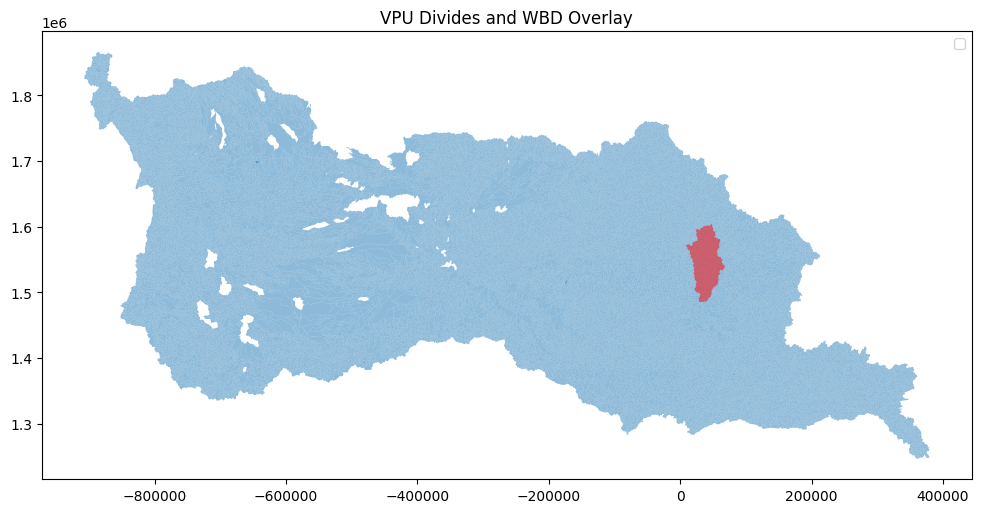

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

huc8_path = "/app/data/NWM/wbd.gpkg"
hf_path = "/app/data/NWM/vpu_11.gpkg"

fig, ax = plt.subplots(figsize=(12, 8))
hf = gpd.read_file(hf_path, layer="divides")
huc8 = gpd.read_file(huc8_path)

hf.plot(ax=ax, alpha=0.5, label='VPU Divides')
huc8.plot(ax=ax, color='red', alpha=0.5, label='WBD')

ax.legend()
plt.title('VPU Divides and WBD Overlay')
plt.show()


In [4]:
divides = gpd.read_file(hf_path, layer="divides")
intersection = gpd.overlay(divides, huc8, how='intersection')


Now, we're going to set up the region, DEM topography, and mask based on the HUC-8 bounds

In [5]:
sf.setup_grid_from_region(
    region = {'geom': intersection},
    res= 50,  # 50m grid resolution
    rotated=True,
    crs=intersection.crs  # NAD83 / Conus Albers
)
print(sf.config)


{'mmax': 1067, 'nmax': 2305, 'dx': 50, 'dy': 50, 'x0': 25951.0, 'y0': 1482591.0, 'rotation': 11.441, 'latitude': 0.0, 'tref': datetime.datetime(2010, 2, 1, 0, 0), 'tstart': datetime.datetime(2010, 2, 1, 0, 0), 'tstop': datetime.datetime(2010, 2, 2, 0, 0), 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 86400, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'manning_land': 0.04, 'manning_sea': 0.02, 'rgh_lev_land': 0.0, 'zsini': 0.0, 'qinf': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 1, 'baro': 1, 'pavbnd': 0, 'gapres': 101200.0, 'stopdepth': 100.0, 'crsgeo': 0, 'btfilter': 60.0, 'viscosity': 1, 'inputformat': 'bin', 'outputformat': 'net', 'cdnrb': 3, 'cdwnd': [0.0, 28.0, 50.0], 'cdval': [0.001, 0.0025, 0.0015], 'epsg': 5070}


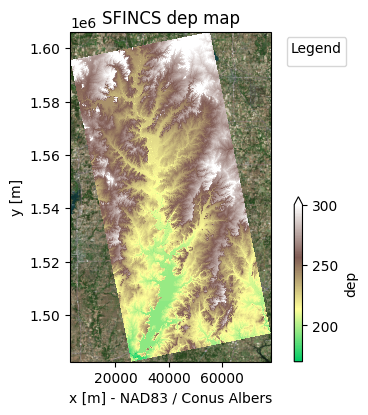

In [6]:
datasets_dep = [{"elevtn": "USGS_seamless_13", "zmin": 0.001}]
dep = sf.setup_dep(datasets_dep=datasets_dep)
_ = sf.plot_basemap(variable="dep", bmap="sat", zoomlevel=12)


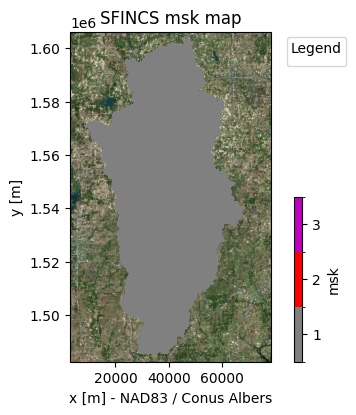

In [7]:
sf.setup_mask_active(include_mask=intersection,reset_mask=True)
_ = sf.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)


In [8]:
end_node = intersection.sort_values("tot_drainage_areasqkm" ,ascending=True).iloc[-1]["toid"]
nexus = gpd.read_file(hf_path, layer="nexus")
downstream_nexus = nexus[nexus["id"] == end_node]


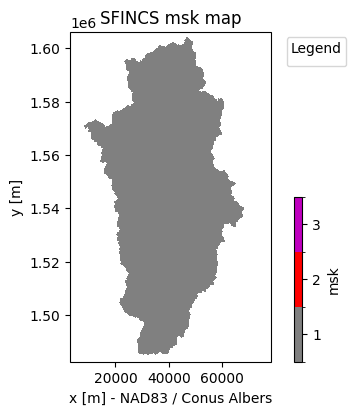

In [9]:
sf.setup_mask_bounds(btype="waterlevel", include_mask=downstream_nexus, reset_bounds=True)
fig, ax = sf.plot_basemap(variable="msk", plot_bounds=True, zoomlevel=12)


Now, we're going to set the river inflow segments based on the headwater flow segments

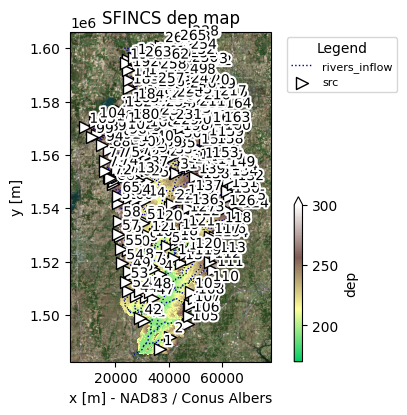

In [10]:
flowlines = gpd.read_file(hf_path, layer="flowpaths")

sf.setup_river_inflow(
    rivers=flowlines, 
    buffer=0.9,
    river_width=10,
    keep_rivers_geom=True,
    src_type="headwater"
)
# print(sf.config)
fig, ax = sf.plot_basemap(variable="dep", plot_bounds=False, bmap="sat", zoomlevel=12)


Each flowline SRC point is one of the headwater flowline segments within the HUC8. There are ~260 in this HUC

In [11]:
sfincs_points = sf.forcing['dis'].vector.to_gdf()
nexus = gpd.read_file(hf_path, layer="network")
joined_flowlines = gpd.sjoin_nearest(sfincs_points, flowlines, how='left')

network = gpd.read_file(hf_path, layer="network")
domain_network = network[network["id"].isin(joined_flowlines["id"])]
all_comids = np.array([list(set([x for _, group in domain_network.groupby("id") 
              for x in group["hf_id"].values.astype(int).tolist()]))])

np.save("/app/data/NWM/coffeyville_feature_ids_huc_8_headwater.npy", all_comids)
output_dir = "/app/data/NWM/huc_8_retro_headwater.zarr"


Now, we're going to pull the retrospective flows from the NWM. This script is a simplified version of the script used in the FIM-C retro_inundation PI-3 deliverable

In [12]:
! python /app/tools/retrospective_nwm.py --feature_id_file /app/data/NWM/coffeyville_feature_ids_huc_8_headwater.npy --date-range 2019-05-20 2019-06-03  --output_path /app/data/NWM/huc_8_retro_headwater.zarr


In [13]:
flow_data = xr.open_zarr(output_dir)
time_range = flow_data.time.values
flow_data

<xarray.Dataset> Size: 2MB
Dimensions:     (feature_id: 863, time: 337)
Coordinates:
  * feature_id  (feature_id) int64 7kB 21796865 21796873 ... 21796859 21796861
  * time        (time) datetime64[ns] 3kB 2019-05-20 ... 2019-06-03
Data variables:
    streamflow  (time, feature_id) float64 2MB dask.array<chunksize=(241, 863), meta=np.ndarray>

In [14]:
flows_arr = np.zeros((len(time_range), sf.forcing['dis'].shape[1]))
for idx, row in joined_flowlines.iterrows():
    _id = row["id"]
    inflow_segments = domain_network[domain_network["id"] == _id]
    group_ids = inflow_segments["hf_id"].values.astype(int)
    subset_flow_data = flow_data.sel(feature_id=group_ids).streamflow.values
    flows_arr[:, idx-1] = np.max(subset_flow_data, axis=1)


In [15]:
sf.setup_config(
    **{
        "tref": "20190520 000000",
        "tstart": "20190520 000000",
        "tstop": "20190603 000000",
        "zsini": 175 # Hardcoded to match domain of interest values
    }
)
index = [1]  # NOTE that the index should start at one
pnts = gpd.points_from_xy(
    [downstream_nexus.geometry.x.values[0]],
    [downstream_nexus.geometry.y.values[0]],
)
bnd = gpd.GeoDataFrame(index=index, geometry=pnts, crs=downstream_nexus.crs)
display(bnd)
time = [
    pd.Timestamp(utils.parse_datetime(sf.config["tstart"])),
    pd.Timestamp(utils.parse_datetime(sf.config["tstop"]))
]
bzs = [[175.0], [175.0]] # hard coding the outflow boundary starting value to around the elevation
bzspd = pd.DataFrame(index=time, columns=index, data=bzs)
display(bzspd)
sf.setup_waterlevel_forcing(timeseries=bzspd, locations=bnd)


,geometry
1,POINT (31149.523 1482885.379)


,1
2019-05-20,175.0
2019-06-03,175.0


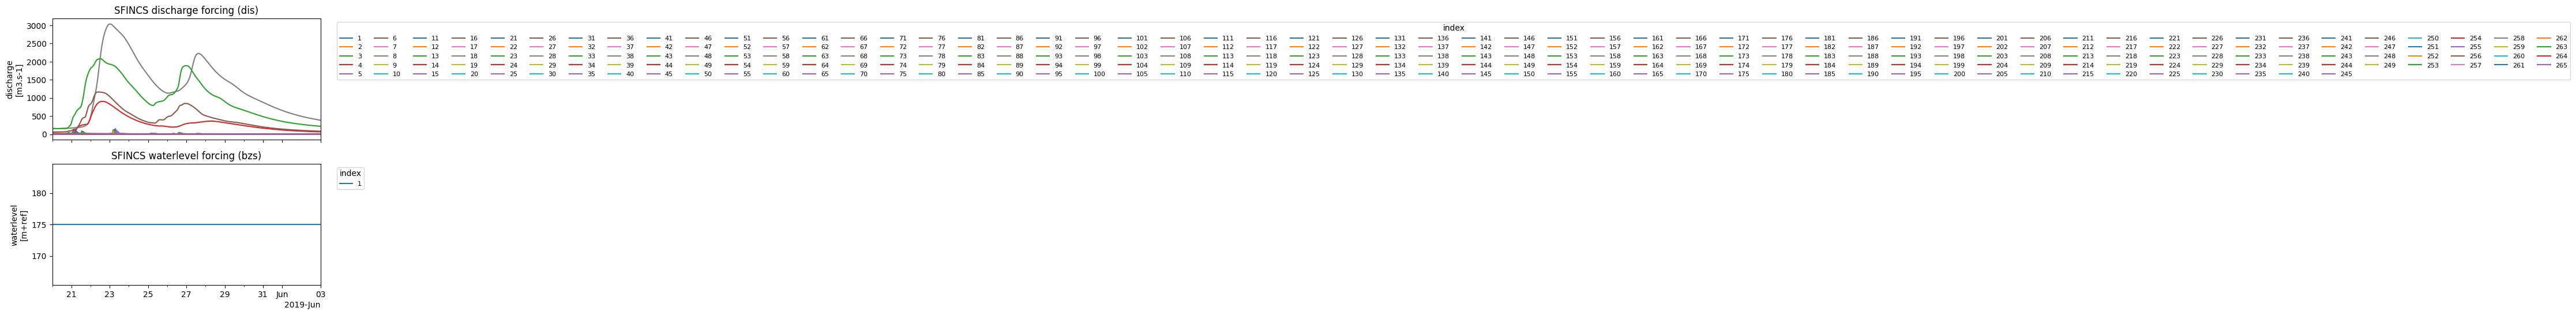

In [16]:
index = sf.forcing["dis"].index
dispd = pd.DataFrame(index=time_range, columns=index, data=flows_arr)
sf.setup_discharge_forcing(timeseries=dispd)
_ = sf.plot_forcing(fn_out="forcing.png")


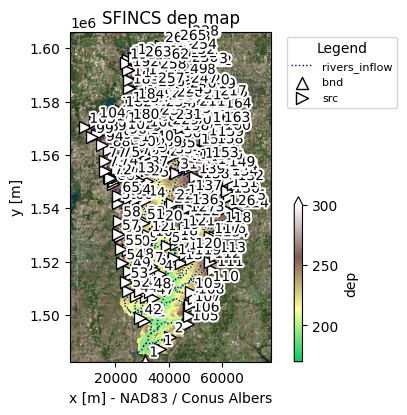

In [17]:
_ = sf.plot_basemap(fn_out="basemap.png", bmap="sat", zoomlevel=12)


In [18]:
sf.write()
dir_list = os.listdir(sf.root)
print(dir_list)


['hydromt_data.yml', 'sfincs.bnd', 'sfincs.dis', 'sfincs.src', 'sfincs_map.nc', 'figs', 'sfincs.dep', 'sfincs.bzs', 'gis', 'sfincs.inp', 'hydromt.log', 'sfincs.ind', 'sfincs.msk']
